<a href="https://colab.research.google.com/github/sinheechan/CAM_Find-a-Car-Park/blob/main/%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98%EA%B8%B0_CAM_Fire_Dataset_240408.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Dataset

In [1]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
# 비전딥러닝 관련 : https://wikidocs.net/135874

In [2]:
# Dataset - https://www.kaggle.com/datasets/daggysheep/find-a-car-park
# Dataset2 - https://www.kaggle.com/datasets/phylake1337/fire-dataset
os.environ['KAGGLE_USERNAME'] = 'sinheechan' # username
os.environ['KAGGLE_KEY'] = 'd8cd8b54b5de471688c0790be19a045c' # key

!kaggle datasets download -d phylake1337/fire-dataset

100% 386M/387M [00:03<00:00, 131MB/s]
100% 387M/387M [00:03<00:00, 109MB/s]


In [3]:
!unzip -q fire-dataset.zip

In [34]:
path='/content/fire_dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,Full
1,.ipynb_checkpoints
2,Free


755
244


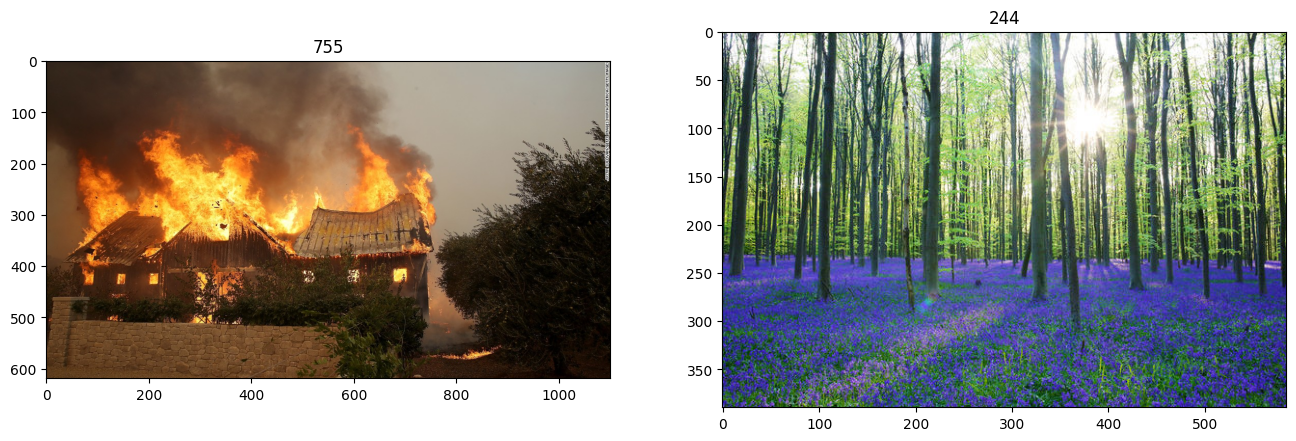

In [36]:
# Preview Dataset
BASE_PATH = 'data'

full_list = glob.glob(os.path.join(BASE_PATH, '/content/fire_dataset/Full/*.png')) # 다 찼음
free_list = glob.glob(os.path.join(BASE_PATH, '/content/fire_dataset/Free/*.png')) # 비었음

print(len(full_list)) # 2095장
print(len(free_list)) # 1067장

# 이미지를 넘파이 배열로 변환
full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))

# full_list
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)


# free_list
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

In [38]:
# DataGenerator

# 어그멘테이션
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1, # val 10%
    preprocessing_function=preprocess_input # keras
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'], #[1, 0] [0, 1]
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 900 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


In [39]:
# Load Model for Transfer Learning
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False) #1000이미지 분류 모델

x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 피기 => 차원축소 // 공간정보를 다루나 CAM은 공간정보를 주력으로 다루므로 정보가 유실될 수 있어 사전에 base 모델을 학습한다.
output = Dense(2, activation='softmax')(x) #[1,0][0,1], 2개

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [40]:
# Switch Layers to be Trainable # 레이어 웨이트 변경 방지
for layer in model.layers:
    layer.trainable = True

In [ ]:
# Train
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

Epoch 1/10


In [ ]:
# Create New Model
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2) 차원수

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

In [ ]:
# Normal Prediction

test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_815061601.jpg'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

In [ ]:
# Draw Activation Map
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) GAP 전
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1) # GAP 생략

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

# 어느 부분을 free이라고 판단했다고 히트맵으로 나타낸 그림이 출력된다.

In [ ]:
# result
# 서로 크로스오버해서 보기

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()